# DATA417- INDIVIDUAL PROJECT

# Nisha Budhathoki - 32632960

# Create the dummy dataset 

In [2]:
# import pandas as pd
# import numpy as np

# # Creating a fake dataset
# np.random.seed(42)
# num_users = 100
# num_movies = 50

# # Generate random user IDs and movie IDs
# user_ids = np.random.randint(1, num_users+1, size=500)
# movie_ids = np.random.randint(1, num_movies+1, size=500)
# ratings = np.random.randint(1, 6, size=500)  # Ratings between 1 and 5

# # Generate random movie titles and genres
# movie_titles = [f"Movie {i}" for i in range(1, num_movies+1)]
# genres = ["Action", "Comedy", "Drama", "Horror", "Sci-Fi"]
# movie_genres = [np.random.choice(genres) for _ in range(num_movies)]

# # Create DataFrames
# ratings_data = pd.DataFrame({'userId': user_ids, 'movieId': movie_ids, 'rating': ratings})
# movies_data = pd.DataFrame({'movieId': range(1, num_movies+1), 'title': movie_titles, 'genres': movie_genres})

# # Save the DataFrames as CSV files
# ratings_data.to_csv('ratings_dummy.csv', index=False)
# movies_data.to_csv('movies_dummy.csv', index=False)

# Distribution of rating in dataset

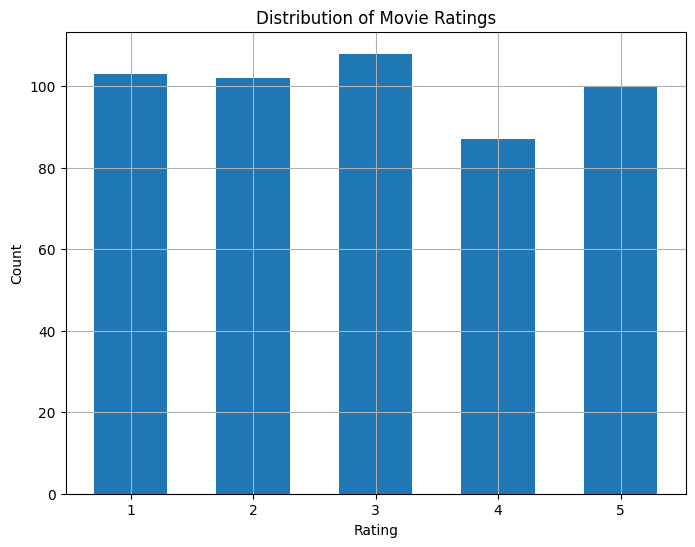

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ratings_data = pd.read_csv("ratings_dummy.csv")
movies_data = pd.read_csv("movies_dummy.csv")

movie_ratings_data = pd.merge(ratings_data, movies_data, on = "movieId")
rating_counts = movie_ratings_data['rating'].value_counts().sort_index()

# Plot the bar plot
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values, width=0.6)  
plt.xticks([1, 2, 3, 4, 5])
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

#####  Below here, first, we used a simple collaborative filtering approach. Then, we updated the algorithm by adding diversity. Next, we evaluated both models using RMSE and MAE. We used the dataset we created, with 80% for training the model and 20% for validation.

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load user ratings and movie data
ratings_data = pd.read_csv("ratings_dummy.csv")
movies_data = pd.read_csv("movies_dummy.csv")
movie_ratings_data = pd.merge(ratings_data, movies_data, on="movieId")

# Split the data into training and testing sets
train_data, test_data = train_test_split(movie_ratings_data, test_size=0.2, random_state=42)


# Prepare the training data for recommendations
df_subset = train_data.drop_duplicates(subset='title', keep='first').copy()
df_subset['genres'] = df_subset['genres'].str.replace('|', ' ', regex=True)

# # Prepare the training data for recommendations
# df_subset = train_data.drop_duplicates(subset='title', keep='first')
# df_subset.loc[:, 'genres'] = df_subset['genres'].str.replace('|', ' ', regex=True)

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_subset['genres'])

# Compute cosine similarity
def compute_cosine_similarity(matrix, chunk_size=1000):
    n = matrix.shape[0]
    similarity_matrix = []
    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        chunk = linear_kernel(matrix[start:end], matrix)
        similarity_matrix.append(chunk)
    return np.vstack(similarity_matrix)

cosine_sim = compute_cosine_similarity(tfidf_matrix)
indices = pd.Series(df_subset.index, index=df_subset['title']).drop_duplicates()

###########################################################################################
###########################################################################################

#Simple collaborative filtering approach
def simple_collaborative_filtering(user_id, train_data):
    user_ratings = train_data[train_data['userId'] == user_id]
    user_ratings = user_ratings[user_ratings['title'].isin(df_subset['title'])]
    
    if user_ratings.empty:
        return pd.DataFrame(columns=['title', 'genres', 'predicted_rating'])
    
    similar_users = train_data[train_data['userId'].isin(user_ratings['userId'].unique())]
    similar_users = similar_users[similar_users['title'].isin(df_subset['title'])]
    
    if similar_users.empty:
        return pd.DataFrame(columns=['title', 'genres', 'predicted_rating'])
    
    similar_users = similar_users.groupby(['title', 'genres']).mean().reset_index()
    similar_users['predicted_rating'] = similar_users['rating']
    
    return similar_users[['title', 'genres', 'predicted_rating']]

##################################################################################################
##################################################################################################

# Generate recommendations with diversity
def generate_recommendations(user_id, diversity_factor, cosine_sim, indices, df_subset, train_data):
    user_ratings = train_data[train_data['userId'] == user_id]
    user_ratings = user_ratings[user_ratings['title'].isin(df_subset['title'])]
    
    if user_ratings.empty:
        return pd.DataFrame(columns=['title', 'genres', 'predicted_rating'])
    
    sim_scores = np.zeros(cosine_sim.shape[0])
    for _, row in user_ratings.iterrows():
        if row['title'] in indices:
            idx = indices[row['title']]
            
            if 0 <= idx < cosine_sim.shape[0]:
                sim_scores += cosine_sim[idx] * row['rating']

    sim_scores = [(i, score) for i, score in enumerate(sim_scores)]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    diversity_scores = np.random.rand(len(sim_scores))
    combined_scores = [(i, score * (1 - diversity_factor) + diversity_scores[i] * diversity_factor) for i, score in sim_scores]
    
    combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)
    combined_scores = combined_scores[:10]
    
    movie_indices = [i[0] for i in combined_scores]
    
    recommendations = df_subset.iloc[movie_indices]
    recommendations['predicted_rating'] = np.mean(user_ratings['rating'])
    return recommendations[['title', 'genres', 'predicted_rating']]

######################################################################################
######################################################################################

# Evaluate the models
def evaluate_model(test_data, model_func, *args):
    y_true = []
    y_pred = []
    for _, row in test_data.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating = row['rating']
        
        recommendations = model_func(user_id, *args)
        predicted_rating = recommendations.loc[recommendations['title'] == row['title'], 'predicted_rating']
        
        if not predicted_rating.empty:
            y_true.append(true_rating)
            y_pred.append(predicted_rating.values[0])
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return rmse, mae


#########################################################################################
#########################################################################################
# # Example
user_id = 65
diversity_factor = 1  # Example diversity factor

# Evaluate simple collaborative filtering
rmse_simple, mae_simple = evaluate_model(test_data, simple_collaborative_filtering, train_data)

# Evaluate the modified approach with diversity
rmse_diverse, mae_diverse = evaluate_model(test_data, generate_recommendations, diversity_factor, cosine_sim, indices, df_subset, train_data)
################################################################################################

# print("Simple Collaborative Filtering - RMSE:", rmse_simple, "MAE:", mae_simple)
# print("Modified Approach with Diversity - RMSE:", rmse_diverse, "MAE:", mae_diverse)



In [7]:

print("Simple Collaborative Filtering - RMSE:", rmse_simple, "MAE:", mae_simple)
print("Modified Approach with Diversity - RMSE:", rmse_diverse, "MAE:", mae_diverse)



Simple Collaborative Filtering - RMSE: 1.5491933384829668 MAE: 1.4
Modified Approach with Diversity - RMSE: 1.3121356283691183 MAE: 1.0873376623376623


# Simple Tikentr User Interface, to show how we could implement this diversity

#### for this we use the updated algorithm with diversity

In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import tkinter as tk
from tkinter import ttk, messagebox, Menu

class RecommendationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Diverse Recommendation System")
        self.root.geometry("800x600")  # Set the window size
        self.load_data()
        self.create_styles()
        self.create_login_frame()

    def create_styles(self):
        style = ttk.Style()
        style.theme_use('clam')

        # Style configurations
        style.configure('TButton', font=('Helvetica', 12), foreground='#fff', background='#008CBA', padding=5)
        style.map('TButton', background=[('active', '#005f87')])
        style.configure('TLabel', font=('Helvetica', 12), foreground='#333', background='#f0f0f0')
        style.configure('TFrame', background='#f0f0f0')
        style.configure('Treeview.Heading', font=('Helvetica', 12, 'bold'), foreground='#333', background='#f0f0f0', anchor='center')
        style.configure('Treeview', font=('Helvetica', 12), foreground='#333', background='#fff', fieldbackground='#fff')

    def load_data(self):
        # Load user ratings and movie data
        self.ratings_data = pd.read_csv("ratings_dummy.csv")
        self.movies_data = pd.read_csv("movies_dummy.csv")
        self.movie_ratings_data = pd.merge(self.ratings_data, self.movies_data, on="movieId")
        
        # Prepare the data for recommendations
        self.df_subset = self.movie_ratings_data.drop_duplicates(subset='title', keep='first')
        self.df_subset['genres'] = self.df_subset['genres'].str.replace('|', ' ')
        
        # Initialize the TF-IDF Vectorizer
        self.tfidf = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = self.tfidf.fit_transform(self.df_subset['genres'])
        
        # Compute cosine similarity
        self.cosine_sim = self.compute_cosine_similarity(self.tfidf_matrix)
        self.indices = pd.Series(self.df_subset.index, index=self.df_subset['title']).drop_duplicates()

    def create_login_frame(self):
        self.login_frame = ttk.Frame(self.root)
        self.login_frame.pack(fill='both', expand=True)

        # Username Label and Entry
        self.username_label = ttk.Label(self.login_frame, text="Username:")
        self.username_label.pack(pady=10)
        self.username_entry = ttk.Entry(self.login_frame, font=("Helvetica", 12))
        self.username_entry.pack(pady=5)

        # Login Button
        self.login_button = ttk.Button(self.login_frame, text="Login", command=self.authenticate_user)
        self.login_button.pack(pady=10)

    def create_menu(self):
        self.menu = Menu(self.root)
        self.root.config(menu=self.menu)

        # Add Genre menu
        self.genre_menu = Menu(self.menu, tearoff=0)
        self.menu.add_cascade(label="Select Genre", menu=self.genre_menu)

        genres = sorted(set(self.df_subset['genres'].str.split().sum()))
        for genre in genres:
            sub_menu = Menu(self.genre_menu, tearoff=0)
            self.genre_menu.add_cascade(label=genre, menu=sub_menu)
            genre_movies = sorted(set(self.movie_ratings_data['title'][self.movie_ratings_data['genres'].str.contains(genre)]))
            for movie in genre_movies:
                sub_menu.add_command(label=movie, command=lambda m=movie: self.select_movie(m))

        # Add Movie menu
        self.movie_menu = Menu(self.menu, tearoff=0)
        self.menu.add_cascade(label="Select Movie You Have Rated", menu=self.movie_menu)
        self.update_movie_menu()

    def update_movie_menu(self):
        # Clear the movie menu before updating
        self.movie_menu.delete(0, tk.END)

        user_rated_movies = sorted(set(self.movie_ratings_data['title'][self.movie_ratings_data['userId'] == self.user_id]))
        for movie in user_rated_movies:
            self.movie_menu.add_command(label=movie, command=lambda m=movie: self.select_movie(m))

    def create_recommendation_frame(self):
        self.recommendation_frame = ttk.Frame(self.root)
        self.recommendation_frame.pack(fill='both', expand=True)
        
        # Diversity Level Label and Slider
        self.diversity_label = tk.Label(self.recommendation_frame, text="Select diversity level:", font=("Helvetica", 15), bg='#f0f0f0', fg='#333')
        self.diversity_label.pack(pady=10)
        self.diversity_slider = tk.Scale(self.recommendation_frame, from_=0, to=1, resolution=0.5, orient=tk.HORIZONTAL, font=("Helvetica", 12), bg='#f0f0f0', fg='#333')
        self.diversity_slider.pack(pady=5)

        # Get Recommendations Button
        self.recommend_button = ttk.Button(self.recommendation_frame, text="Get Recommendations", command=self.get_recommendations)
        self.recommend_button.pack(pady=10)

        # Recommendations Table
        self.recommendations_table = ttk.Treeview(self.recommendation_frame, columns=("Title", "Genres"), show='headings')
        self.recommendations_table.heading("Title", text="Title", anchor="center")
        self.recommendations_table.heading("Genres", text="Genres", anchor="center")
        self.recommendations_table.column("Title", anchor="center")
        self.recommendations_table.column("Genres", anchor="center")
        self.recommendations_table.pack(pady=10, fill=tk.BOTH, expand=True)

        # Logout Button
        self.logout_button = ttk.Button(self.recommendation_frame, text="Logout", command=self.logout)
        self.logout_button.pack(pady=10)

    def show_recommendation_frame(self):
        self.login_frame.pack_forget()
        self.create_recommendation_frame()
        self.create_menu()
        self.recommendation_frame.pack(fill='both', expand=True)

    def authenticate_user(self):
        username = self.username_entry.get()
        # Check if the username exists in the user data
        if username.isdigit() and int(username) in self.ratings_data['userId'].values:
            messagebox.showinfo("Login", "Login successful!")
            self.user_id = int(username)  # Set the user ID
            self.show_recommendation_frame()
        else:
            messagebox.showerror("Login", "Invalid username")

    def logout(self):
        self.clear_menu()
        self.recommendation_frame.pack_forget()
        self.create_login_frame()

    def clear_menu(self):
        self.root.config(menu='')
        self.menu = Menu(self.root)
        self.root.config(menu=self.menu)

    def compute_cosine_similarity(self, matrix, chunk_size=1000):
        n = matrix.shape[0]
        similarity_matrix = []
        for start in range(0, n, chunk_size):
            end = min(start + chunk_size, n)
            chunk = linear_kernel(matrix[start:end], matrix)
            similarity_matrix.append(chunk)
        return np.vstack(similarity_matrix)

    def select_movie(self, movie):
        self.selected_movie = movie
        messagebox.showinfo("Movie Selected", f"You have selected movie: {movie}")

    def get_recommendations(self):
        if hasattr(self, 'user_id'):
            genre = getattr(self, 'selected_genre', None)
            movie = getattr(self, 'selected_movie', None)
            diversity_factor = self.diversity_slider.get()
            recommendations = self.generate_recommendations(self.user_id, genre, movie, diversity_factor)
            if recommendations.empty:
                self.recommendations_table.delete(*self.recommendations_table.get_children())
                self.recommendations_table.insert("", tk.END, values=("No recommendations available for this user.", ""))
            else:
                self.recommendations_table.delete(*self.recommendations_table.get_children())
                for _, row in recommendations.iterrows():
                    self.recommendations_table.insert("", tk.END, values=(row['title'], row['genres']))
        else:
            messagebox.showwarning("Warning", "Please login first")

    def generate_recommendations(self, user_id, genre, movie, diversity_factor):
        # Filter the dataset for the specified user
        user_ratings = self.movie_ratings_data[self.movie_ratings_data['userId'] == user_id]
        
        # Filter out movies that are not in df_subset
        user_ratings = user_ratings[user_ratings['title'].isin(self.df_subset['title'])]
        
        # Check if the user has rated any movies
        if user_ratings.empty:
            return pd.DataFrame(columns=['title', 'genres'])
        
        # Initialize similarity scores
        sim_scores = np.zeros(self.cosine_sim.shape[0])

        # Aggregate similarity scores based on user ratings
        for _, row in user_ratings.iterrows():
            if row['title'] in self.indices:
                idx = self.indices[row['title']]
                if 0 <= idx < self.cosine_sim.shape[0]:  # Ensure the index is within bounds
                    sim_scores += self.cosine_sim[idx] * row['rating']

        sim_scores = [(i, score) for i, score in enumerate(sim_scores)]
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Adding diversity factor
        diversity_scores = np.random.rand(len(sim_scores))  # Random diversity scores for demonstration
        combined_scores = [(i, score * (1 - diversity_factor) + diversity_scores[i] * diversity_factor) for i, score in sim_scores]
        
        combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)
        combined_scores = combined_scores[:10]
        
        movie_indices = [i[0] for i in combined_scores]
        
        recommendations = self.df_subset.iloc[movie_indices]
        return recommendations[['title', 'genres']]

if __name__ == "__main__":
    root = tk.Tk()
    app = RecommendationApp(root)
    root.mainloop()
